In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.insert(0, '/home/xhding/workspaces/torch-deep-retina')
import os
import scipy
import h5py
import numpy as np
import matplotlib.pyplot as plt
import torch
import pyret
from kinetic.evaluation import *
from kinetic.utils import *
from kinetic.config import get_custom_cfg
from kinetic.data import *
from kinetic.notebook.functions import *
import kinetic.models as models
from kinetic.models import *

In [15]:
with h5py.File('/home/xhding/tem_stim/21-01-26/fullfield.h5', 'r') as f:
    stimulus =  np.asarray(f['train']['stimulus'][:, 25, 25]).astype('float32')
    resp = np.asarray(f['train']['response']['firing_rate_10ms'])

In [17]:
stimuli = stimulus[:40060].reshape((10,-1))
responses = np.swapaxes(resp, 0, 1)[:40060].reshape((10, -1, 11))

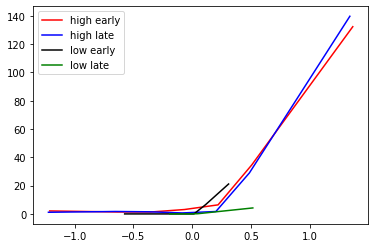

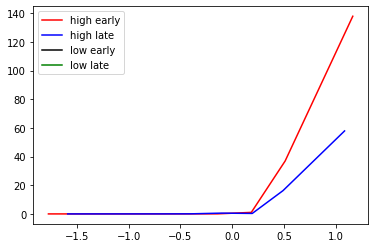

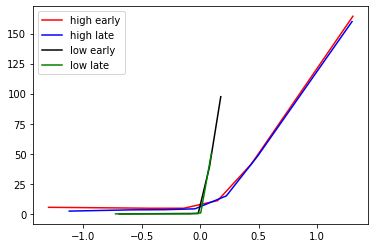

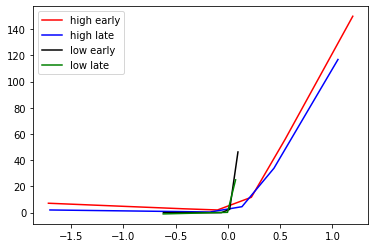

In [11]:
for cell in [1, 2, 7, 10]:
    _, x_he, nonlinear_he = LN_model_multi_trials_fourier(stimuli, responses, 0.35, cell, 0, 500)
    _, x_hl, nonlinear_hl = LN_model_multi_trials_fourier(stimuli, responses, 0.35, cell, 1400, 2000)
    _, x_le, nonlinear_le = LN_model_multi_trials_fourier(stimuli, responses, 0.05, cell, 2000, 2500)
    _, x_ll, nonlinear_ll = LN_model_multi_trials_fourier(stimuli, responses, 0.05, cell, 3400, 4000)
    plt.plot(x_he, nonlinear_he, 'r', label='high early')
    plt.plot(x_hl, nonlinear_hl, 'b', label='high late')
    plt.plot(x_le, nonlinear_le, 'k', label='low early')
    plt.plot(x_ll, nonlinear_ll, 'g', label='low late')
    plt.legend()
    plt.show()

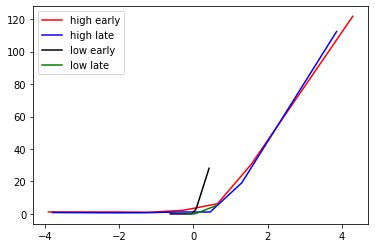

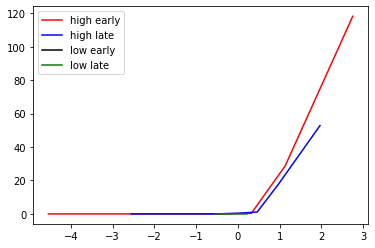

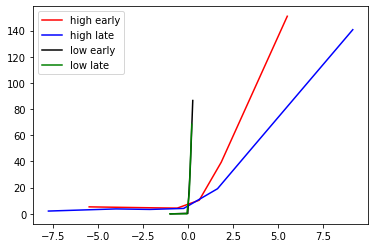

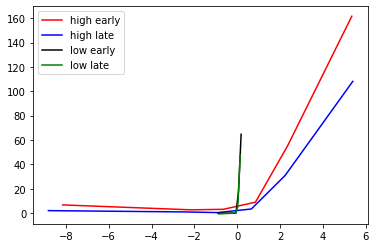

In [12]:
for cell in [1,2,7,10]:
    _, x_he, nonlinear_he = LN_model_multi_trials(stimuli, responses, 0.35, cell, 0, 500, sta_type='revcor')
    _, x_hl, nonlinear_hl = LN_model_multi_trials(stimuli, responses, 0.35, cell, 1400, 2000, sta_type='revcor')
    _, x_le, nonlinear_le = LN_model_multi_trials(stimuli, responses, 0.05, cell, 2000, 2500, sta_type='revcor')
    _, x_ll, nonlinear_ll = LN_model_multi_trials(stimuli, responses, 0.05, cell, 3400, 4000, sta_type='revcor')
    plt.plot(x_he, nonlinear_he, 'r', label='high early')
    plt.plot(x_hl, nonlinear_hl, 'b', label='high late')
    plt.plot(x_le, nonlinear_le, 'k', label='low early')
    plt.plot(x_ll, nonlinear_ll, 'g', label='low late')
    plt.legend()
    plt.show()

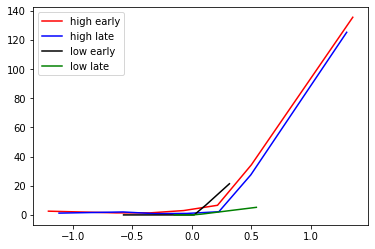

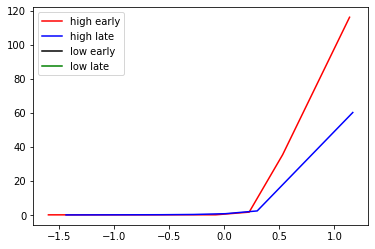

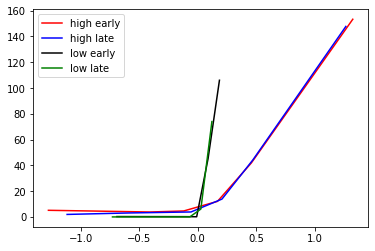

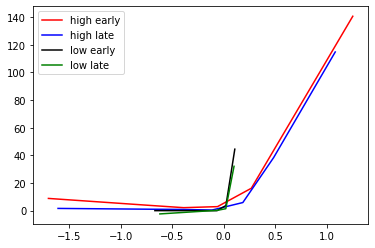

In [13]:
for cell in [1,2,7,10]:
    _, x_he, nonlinear_he = LN_model_multi_trials(stimuli, responses, 0.35, cell, 0, 500, sta_type='fourier')
    _, x_hl, nonlinear_hl = LN_model_multi_trials(stimuli, responses, 0.35, cell, 1400, 2000, sta_type='fourier')
    _, x_le, nonlinear_le = LN_model_multi_trials(stimuli, responses, 0.05, cell, 2000, 2500, sta_type='fourier')
    _, x_ll, nonlinear_ll = LN_model_multi_trials(stimuli, responses, 0.05, cell, 3400, 4000, sta_type='fourier')
    plt.plot(x_he, nonlinear_he, 'r', label='high early')
    plt.plot(x_hl, nonlinear_hl, 'b', label='high late')
    plt.plot(x_le, nonlinear_le, 'k', label='low early')
    plt.plot(x_ll, nonlinear_ll, 'g', label='low late')
    plt.legend()
    plt.show()

In [4]:
cfg = get_custom_cfg('kinetics_both')
device = torch.device('cuda:2')
model_func = getattr(models, cfg.Model.name)
model_kwargs = dict(cfg.Model)
model = model_func(**model_kwargs).to(device)
checkpoint = torch.load('/home/xhding/saved_model/kinetics_both/epoch_035_loss_-60.05_pearson_natural_0.4560_pearson_noise_0.4365.pth', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

KineticsModel(
  (bipolar): Sequential(
    (0): LinearStackedConv2d(
      bias=True, abs_bnorm=False
      (convs): Sequential(
        (0): Conv2d(40, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (1): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (4): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (5): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (6): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
      )
    )
    (1): Sigmoid()
    (2): Reshape(shape=(-1, 8, 1296))
  )
  (kinetics): Kinetics()
  (spiking_block): Sequential(
    (0): ReLU()
  )
  (amacrine): Sequential(
    (0): Reshape(shape=(-1, 8, 36, 36))
    (1): LinearStackedConv2d(
      bias=True, abs_bnorm=False
      (convs): Sequential(
        (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bi

In [5]:
data_kwargs = dict(cfg.Data)
data_kwargs['stim'] = 'naturalscene'
train_dataset_natural = MyDataset(stim_sec='train', **data_kwargs)
test_data_natural =  DataLoader(dataset=MyDataset(stim_sec='test', stats=train_dataset_natural.stats, **data_kwargs))
data_kwargs['stim'] = 'fullfield_whitenoise'
train_dataset_noise = MyDataset(stim_sec='train', **data_kwargs)
test_data_noise =  DataLoader(dataset=MyDataset(stim_sec='test', stats=train_dataset_noise.stats, **data_kwargs))

In [6]:
pearson = pearsonr_eval(model, test_data_natural, 4, device)
print(pearson)

0.603436750261093


In [7]:
pearson = pearsonr_eval(model, test_data_noise, 4, device, start_idx=4000)
print(pearson)

0.5818033726835389


In [35]:
checkpoint['model_state_dict'].keys()

odict_keys(['kinetics_w', 'kinetics_b', 'bipolar.0.convs.0.weight', 'bipolar.0.convs.1.weight', 'bipolar.0.convs.2.weight', 'bipolar.0.convs.3.weight', 'bipolar.0.convs.4.weight', 'bipolar.0.convs.5.weight', 'bipolar.0.convs.6.weight', 'bipolar.0.convs.6.bias', 'kinetics.ka', 'kinetics.kfi', 'kinetics.kfr', 'kinetics.ksi', 'kinetics.ksr', 'kinetics.ksr_2', 'amacrine.1.convs.0.weight', 'amacrine.1.convs.1.weight', 'amacrine.1.convs.2.weight', 'amacrine.1.convs.3.weight', 'amacrine.1.convs.4.weight', 'amacrine.1.convs.4.bias', 'ganglion.0.weight'])

In [ ]:
device = torch.device('cuda:3')
cfg_name = 'kinetics_both'
checkpoint_path = '/home/xhding/archived_models/kinetics/full.pth'
checkpoint_path_one_pixel = '/home/xhding/archived_models/kinetics/one_pixel.pth'
_, _, layer_outs = analyze(cfg_name, checkpoint_path, checkpoint_path_one_pixel, stimulus, device, nrepeats=10)

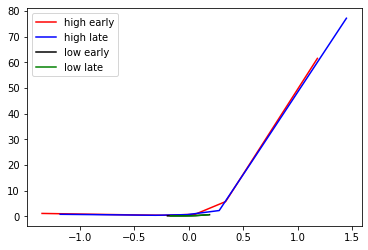

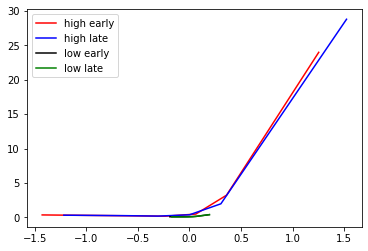

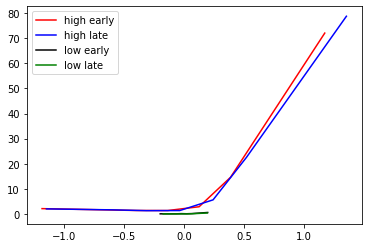

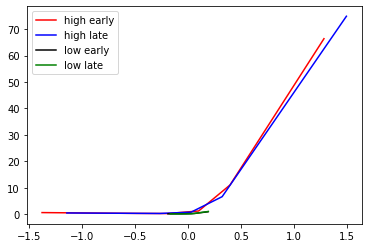

In [41]:
contrast_adaptation_LN(model, device)

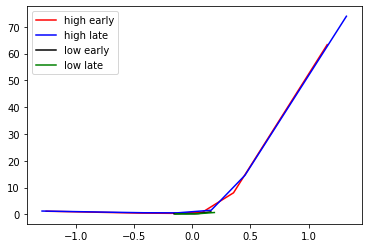

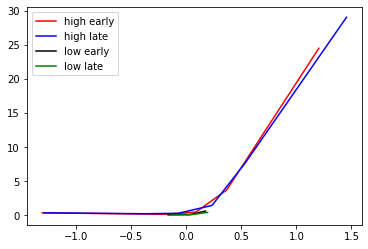

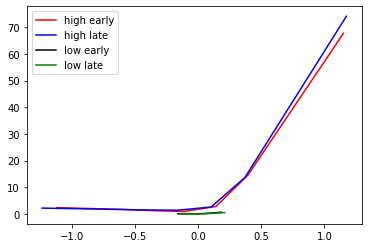

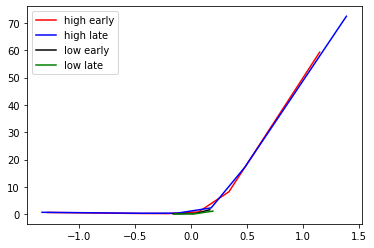

In [55]:
model.kinetics.ksi.data = torch.tensor([[1.70]]).to(device)
model.kinetics.ksr.data = torch.tensor([[2.36]]).to(device)
contrast_adaptation_LN(model, device)

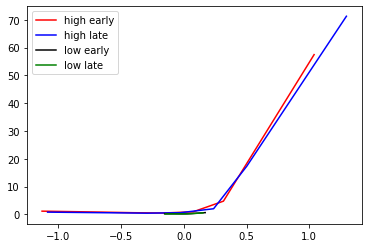

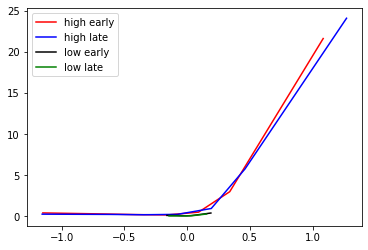

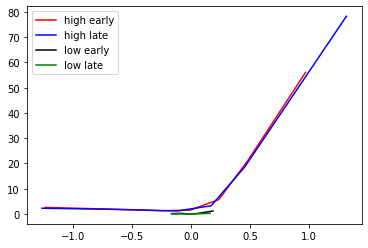

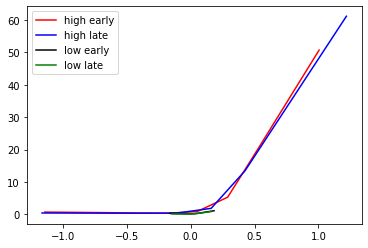

In [56]:
model.kinetics.ksi.data = torch.tensor([[0.77]]).to(device)
model.kinetics.ksr.data = torch.tensor([[1.58]]).to(device)
contrast_adaptation_LN(model, device)

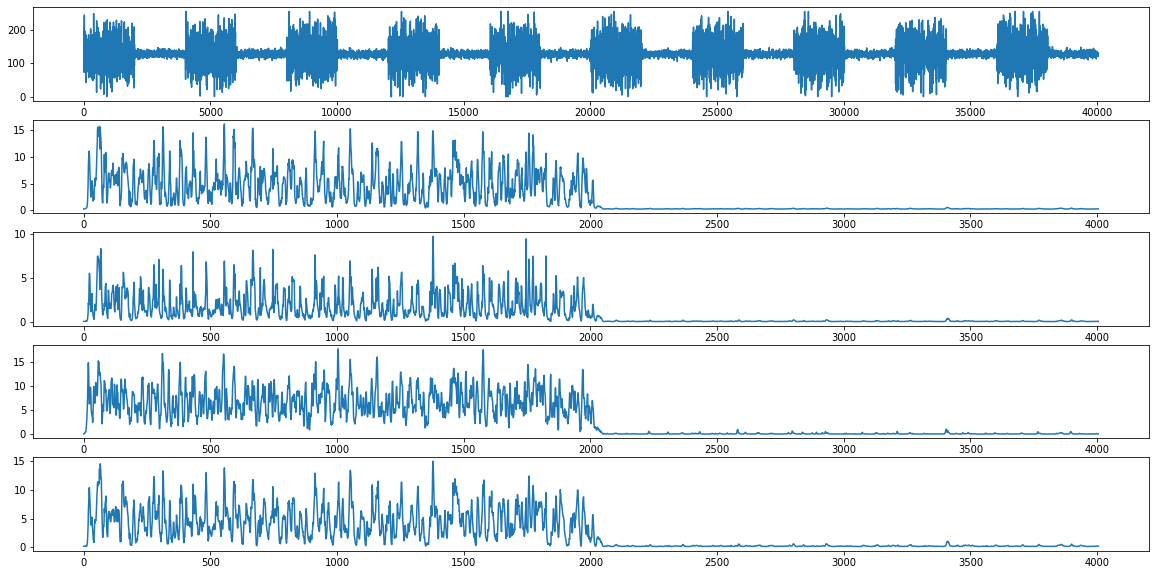

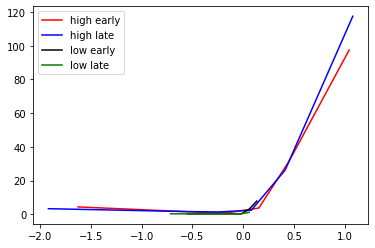

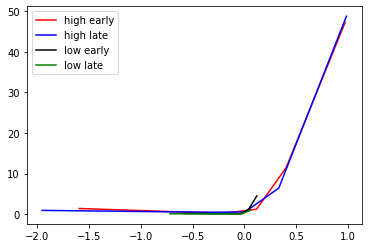

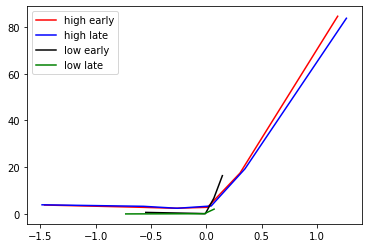

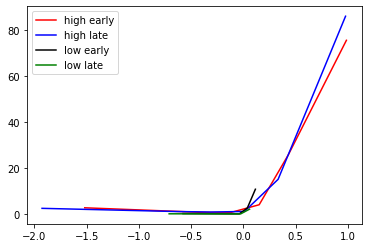

0.47653886719985983


In [50]:
model.kinetics.ksi.data = torch.tensor([[0.]]).to(device)
model.kinetics.ksr.data = torch.tensor([[0.]]).to(device)
pearson, _, _ = contrast_adaptation_fullfield_multi(model, device)
print(pearson)

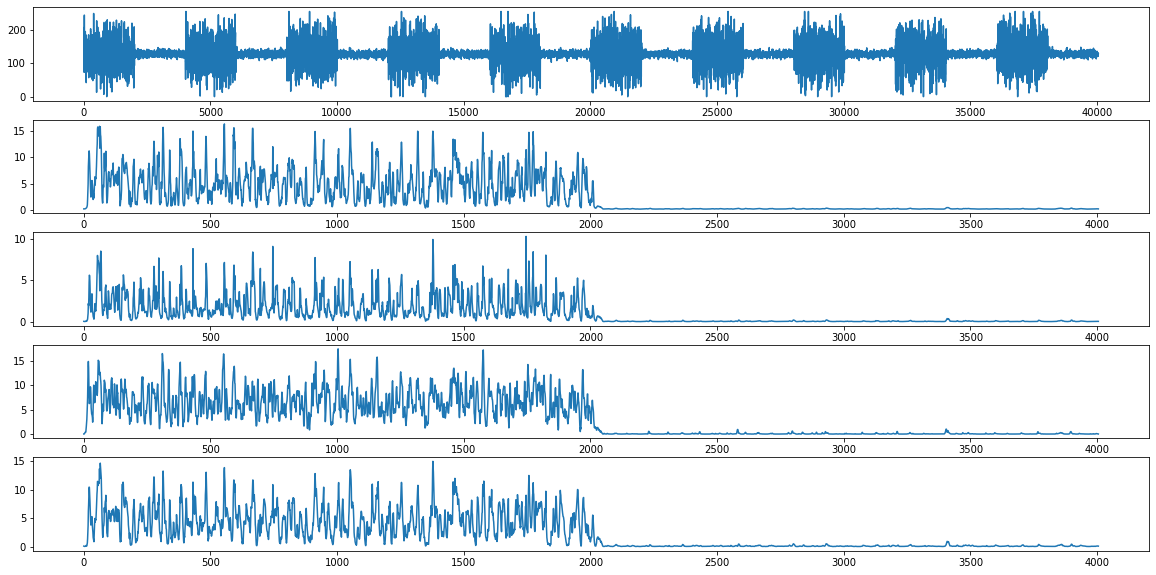

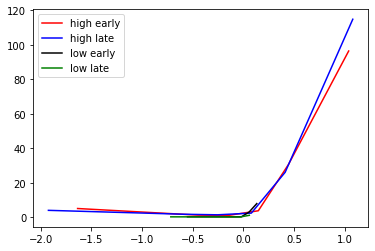

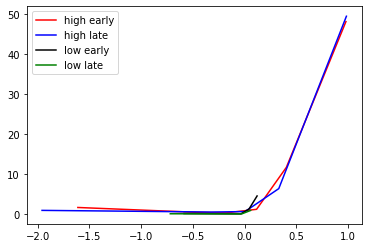

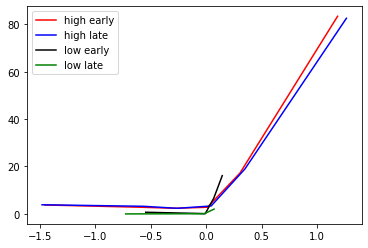

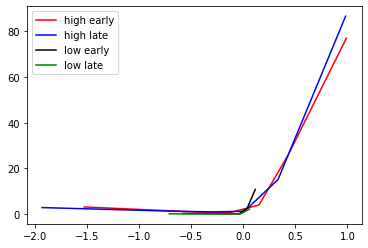

0.4776964196934431


In [51]:
model.kinetics.ksi.data = torch.tensor([[0.77]]).to(device)
model.kinetics.ksr.data = torch.tensor([[1.58]]).to(device)
pearson, _, _ = contrast_adaptation_fullfield_multi(model, device)
print(pearson)

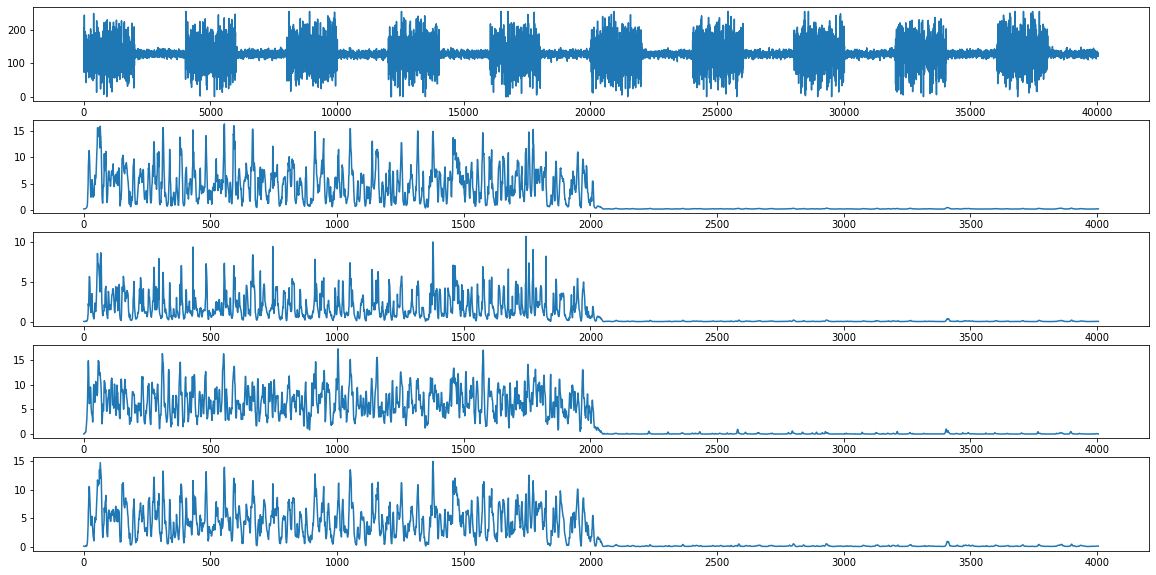

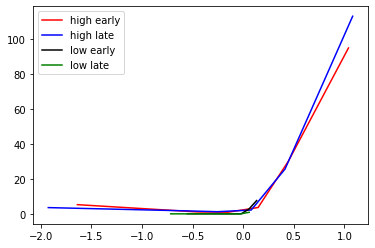

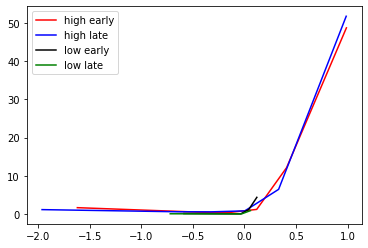

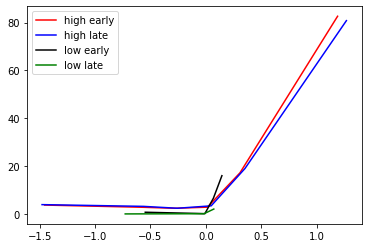

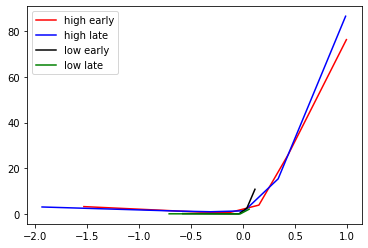

0.478565430588495


In [52]:
model.kinetics.ksi.data = torch.tensor([[2.28]]).to(device)
model.kinetics.ksr.data = torch.tensor([[2.70]]).to(device)
pearson, _, _ = contrast_adaptation_fullfield_multi(model, device)
print(pearson)

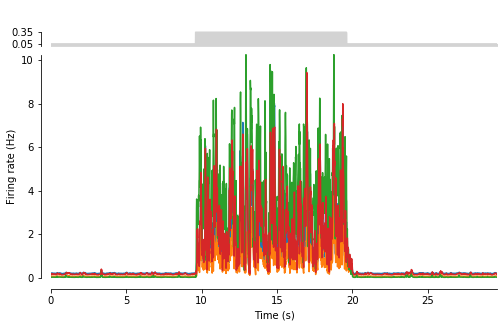

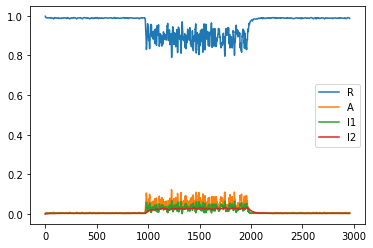

In [45]:
model.kinetics.ksi.data = torch.tensor([[2.28]]).to(device)
model.kinetics.ksr.data = torch.tensor([[2.70]]).to(device)
filter_len = 40
channel = 0
_, layer_outs = contrast_adaptation_kinetic(model, device, insp_keys=['kinetics'], nrepeats=10)

plt.plot(np.arange(3000 - filter_len),layer_outs['kinetics'][:, 0, channel], label='R')
plt.plot(np.arange(3000 - filter_len),layer_outs['kinetics'][:, 1, channel], label='A')
plt.plot(np.arange(3000 - filter_len),layer_outs['kinetics'][:, 2, channel], label='I1')
plt.plot(np.arange(3000 - filter_len),layer_outs['kinetics'][:, 3, channel], label='I2')
plt.legend()
plt.show()

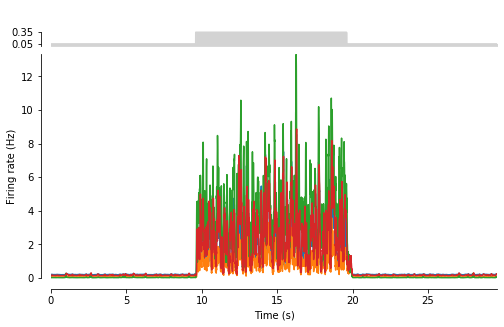

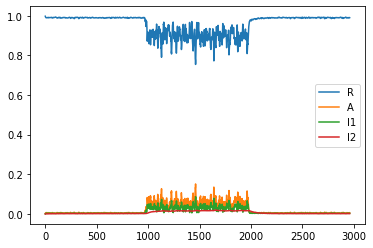

In [49]:
model.kinetics.ksi.data = torch.tensor([[0.77]]).to(device)
model.kinetics.ksr.data = torch.tensor([[1.58]]).to(device)
filter_len = 40
channel = 0
_, layer_outs = contrast_adaptation_kinetic(model, device, insp_keys=['kinetics'], nrepeats=10)

plt.plot(np.arange(3000 - filter_len),layer_outs['kinetics'][:, 0, channel], label='R')
plt.plot(np.arange(3000 - filter_len),layer_outs['kinetics'][:, 1, channel], label='A')
plt.plot(np.arange(3000 - filter_len),layer_outs['kinetics'][:, 2, channel], label='I1')
plt.plot(np.arange(3000 - filter_len),layer_outs['kinetics'][:, 3, channel], label='I2')
plt.legend()
plt.show()

In [6]:
device = torch.device('cuda:2')
checkpoint_path = '/home/xhding/saved_model/kinetics_both/epoch_045_loss_-60.15_pearson_natural_0.4562_pearson_noise_0.4354.pth'
checkpoint_path_one_pixel = '/home/xhding/saved_model/kinetics_one_pixel/epoch_005_loss_1.46_pearson_0.4466.pth'
cfg = get_custom_cfg('kinetics_both')
checkpoint = torch.load(checkpoint_path, map_location=device)
model_func = getattr(models, cfg.Model.name)
model_kwargs = dict(cfg.Model)
model = model_func(**model_kwargs).to(device)
model.load_state_dict(checkpoint['model_state_dict'])
if checkpoint_path_one_pixel != '':
    checkpoint_one_pixel = torch.load(checkpoint_path_one_pixel, map_location=device)
    model.kinetics.ksi.data = checkpoint_one_pixel['model_state_dict']['kinetics.ksi']
    model.kinetics.ksr.data = checkpoint_one_pixel['model_state_dict']['kinetics.ksr']
    try:
        if model.ksr_gain:
            model.kinetics.ksr_2.data = checkpoint_one_pixel['model_state_dict']['kinetics.ksr_2']
    except:
        pass
model.eval()

KineticsModel(
  (bipolar): Sequential(
    (0): LinearStackedConv2d(
      bias=True, abs_bnorm=False
      (convs): Sequential(
        (0): Conv2d(40, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (1): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (4): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (5): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (6): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
      )
    )
    (1): Sigmoid()
    (2): Reshape(shape=(-1, 8, 1296))
  )
  (kinetics): Kinetics()
  (spiking_block): Sequential(
    (0): ReLU()
  )
  (amacrine): Sequential(
    (0): Reshape(shape=(-1, 8, 36, 36))
    (1): LinearStackedConv2d(
      bias=True, abs_bnorm=False
      (convs): Sequential(
        (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bi

0.5867187410334063


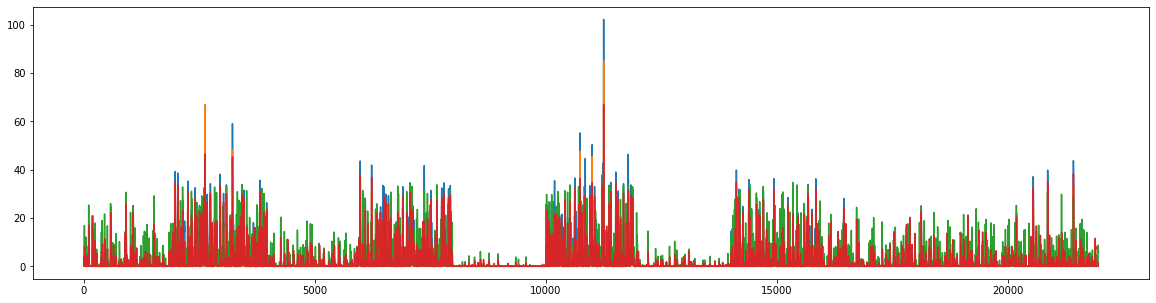

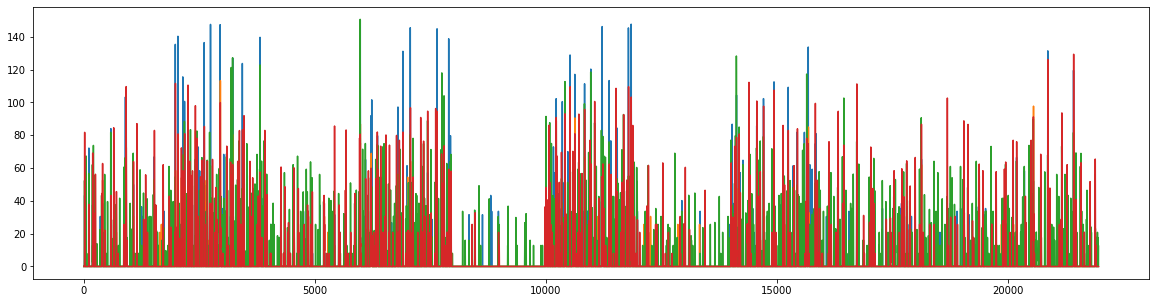

In [7]:
data_kwargs = dict(cfg.Data)
data_kwargs['stim'] = 'fullfield_whitenoise'
train_dataset_noise = MyDataset(stim_sec='train', **data_kwargs)
test_data_noise =  DataLoader(dataset=MyDataset(stim_sec='test', stats=train_dataset_noise.stats, **data_kwargs))
test_pc_noise, pred_noise, targ_noise = pearsonr_eval(model, test_data_noise, 4, device, with_responses=True,
                                                      I20=cfg.Data.I20, start_idx=cfg.Data.start_idx, hs_mode=cfg.Data.hs_mode)

print(test_pc_noise)
plt.figure(figsize=(20,5))
plt.plot(pred_noise)
plt.show()
plt.figure(figsize=(20,5))
plt.plot(targ_noise)
plt.show()

0.5867187410334063


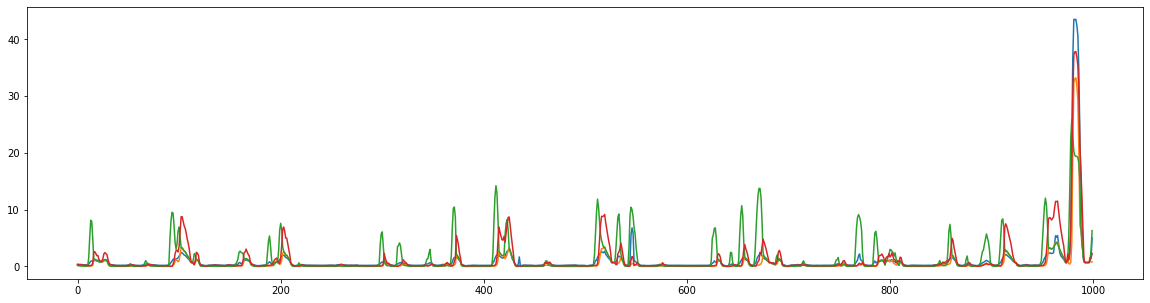

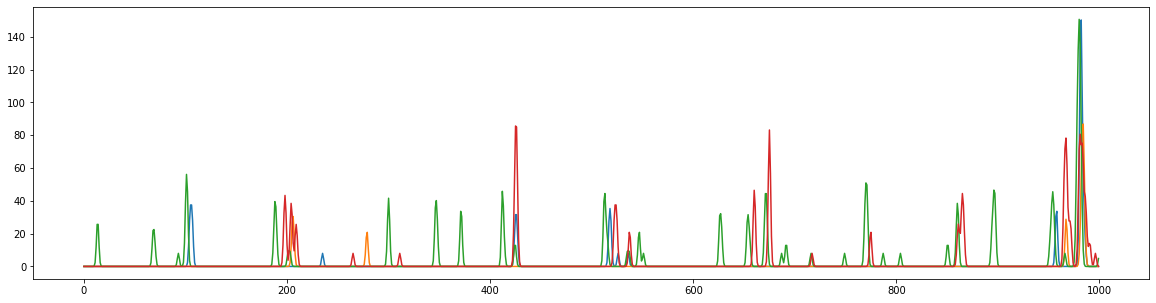

In [8]:
print(test_pc_noise)
plt.figure(figsize=(20,5))
plt.plot(pred_noise[5000:6000])
plt.show()
plt.figure(figsize=(20,5))
plt.plot(targ_noise[5000:6000])
plt.show()

0.33052794159470916


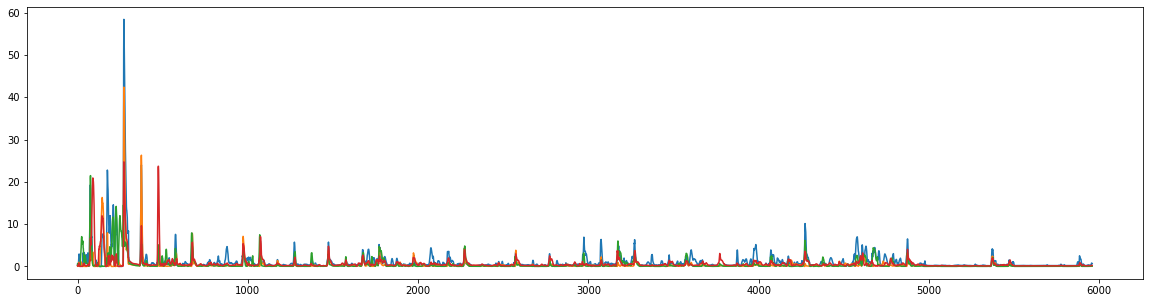

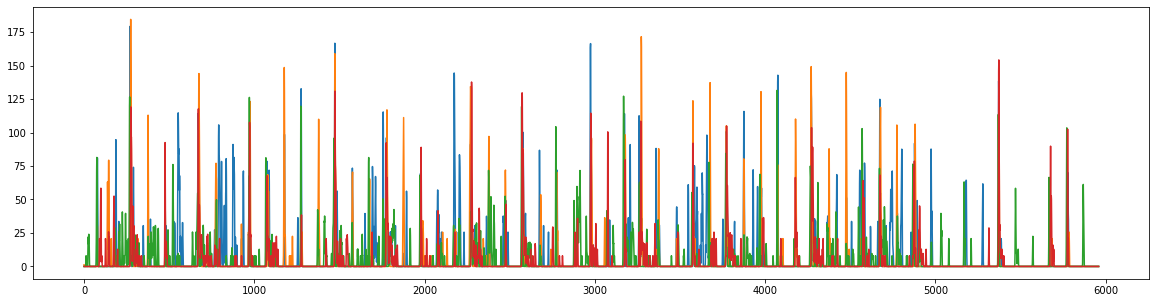

In [13]:
data_kwargs = dict(cfg.Data)
data_kwargs['stim'] = 'naturalscene'
train_dataset_natural = MyDataset(stim_sec='train', **data_kwargs)
test_data_natural =  DataLoader(dataset=MyDataset(stim_sec='test', stats=train_dataset_natural.stats, **data_kwargs))
test_pc_natural, pred_natural, targ_natural = pearsonr_eval(model, test_data_natural, 4, device, with_responses=True,
                                                            I20=cfg.Data.I20, start_idx=cfg.Data.start_idx, hs_mode=cfg.Data.hs_mode)

print(test_pc_natural)
plt.figure(figsize=(20,5))
plt.plot(pred_natural)
plt.show()
plt.figure(figsize=(20,5))
plt.plot(targ_natural)
plt.show()

In [7]:
data_kwargs = dict(cfg.Data)
data_kwargs['stim'] = 'fullfield_whitenoise'
train_dataset = MyDataset(stim_sec='train', **data_kwargs)
train_data = DataLoader(dataset=train_dataset)
epoch_loss = 0
hs = get_hs(model, 1, device, I20=None, mode='single')
y_preds = []
y_targs = []
with torch.no_grad():
    for idx,(x,y) in enumerate(tqdm(train_data)):
        x = x.to(device)
        y = y.double().to(device)
        out, hs = model(x, hs)
        y_preds.append(out.double())
        y_targs.append(y)
        if idx % 1000 == (1000 - 1):
            y_pred = torch.stack(y_preds, dim=2)
            y_targ = torch.stack(y_targs, dim=2)
            loss = nn.MSELoss()(y_pred, y_targ)
            epoch_loss += loss.detach().cpu().numpy()
            y_preds = []
            y_targs = []
    epoch_loss = epoch_loss / len(train_dataset) * 1000
print(epoch_loss)

100%|██████████| 239960/239960 [09:47<00:00, 408.21it/s]

207.9161872872622


In [8]:
data_kwargs = dict(cfg.Data)
data_kwargs['stim'] = 'fullfield_whitenoise'
train_dataset = MyDataset(stim_sec='train', **data_kwargs)
train_data = DataLoader(dataset=train_dataset)
epoch_loss = 0
hs = get_hs(model, 1, device, I20=None, mode='single')
y_preds = []
y_targs = []
with torch.no_grad():
    for idx,(x,y) in enumerate(tqdm(train_data)):
        x = x.to(device)
        y = y.double().to(device)
        out, hs = model(x, hs)
        y_preds.append(out.double())
        y_targs.append(y)
        if idx % 1000 == (1000 - 1):
            y_pred = torch.stack(y_preds, dim=2)
            y_targ = torch.stack(y_targs, dim=2)
            loss = temporal_frequency_normalized_loss(y_pred, y_targ, nn.MSELoss(), device, num_units=4)
            epoch_loss += loss.detach().cpu().numpy()
            y_preds = []
            y_targs = []
    epoch_loss = epoch_loss / len(train_dataset) * 1000
print(epoch_loss)

100%|██████████| 239960/239960 [09:48<00:00, 407.86it/s]

30.96152559421239


In [4]:
device = torch.device('cuda:2')
checkpoint_path = '/home/xhding/saved_model/kinetics_both/epoch_045_loss_-60.15_pearson_natural_0.4562_pearson_noise_0.4354.pth'
checkpoint_path_one_pixel = ''
cfg = get_custom_cfg('kinetics_both')
checkpoint = torch.load(checkpoint_path, map_location=device)
model_func = getattr(models, cfg.Model.name)
model_kwargs = dict(cfg.Model)
model = model_func(**model_kwargs).to(device)
model.load_state_dict(checkpoint['model_state_dict'])
if checkpoint_path_one_pixel != '':
    checkpoint_one_pixel = torch.load(checkpoint_path_one_pixel, map_location=device)
    model.kinetics.ksi.data = checkpoint_one_pixel['model_state_dict']['kinetics.ksi']
    model.kinetics.ksr.data = checkpoint_one_pixel['model_state_dict']['kinetics.ksr']
    try:
        if model.ksr_gain:
            model.kinetics.ksr_2.data = checkpoint_one_pixel['model_state_dict']['kinetics.ksr_2']
    except:
        pass
model.eval()

KineticsModel(
  (bipolar): Sequential(
    (0): LinearStackedConv2d(
      bias=True, abs_bnorm=False
      (convs): Sequential(
        (0): Conv2d(40, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (1): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (4): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (5): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (6): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
      )
    )
    (1): Sigmoid()
    (2): Reshape(shape=(-1, 8, 1296))
  )
  (kinetics): Kinetics()
  (spiking_block): Sequential(
    (0): ReLU()
  )
  (amacrine): Sequential(
    (0): Reshape(shape=(-1, 8, 36, 36))
    (1): LinearStackedConv2d(
      bias=True, abs_bnorm=False
      (convs): Sequential(
        (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bi

0.5791256893926713


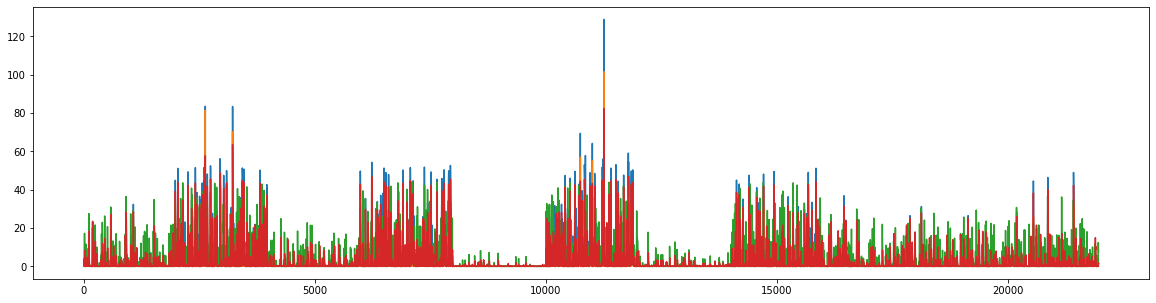

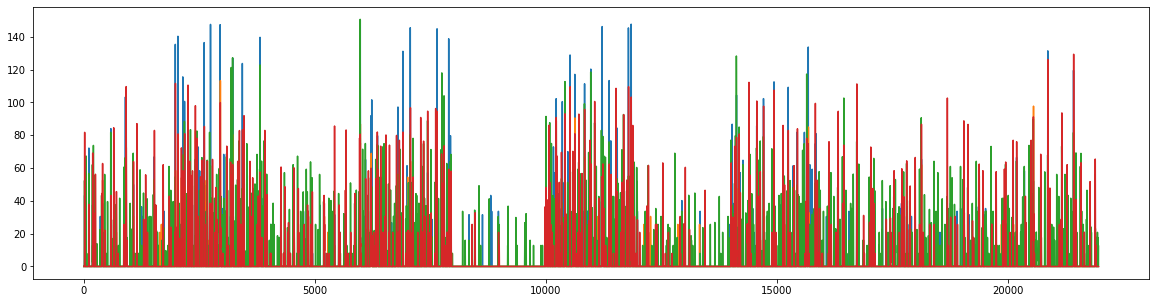

In [51]:
data_kwargs = dict(cfg.Data)
data_kwargs['stim'] = 'fullfield_whitenoise'
train_dataset_noise = MyDataset(stim_sec='train', **data_kwargs)
test_data_noise =  DataLoader(dataset=MyDataset(stim_sec='test', stats=train_dataset_noise.stats, **data_kwargs))
test_pc_noise, pred_noise2, targ_noise2 = pearsonr_eval(model, test_data_noise, 4, device, with_responses=True,
                                                      I20=cfg.Data.I20, start_idx=cfg.Data.start_idx, hs_mode=cfg.Data.hs_mode)

print(test_pc_noise)
plt.figure(figsize=(20,5))
plt.plot(pred_noise2)
plt.show()
plt.figure(figsize=(20,5))
plt.plot(targ_noise2)
plt.show()

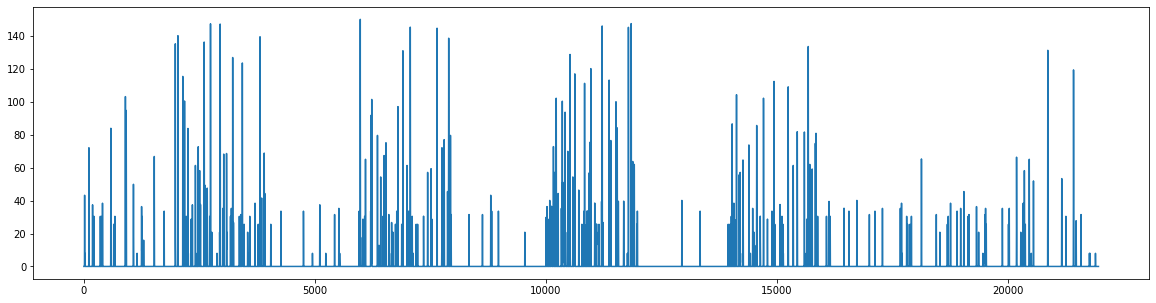

In [53]:
plt.figure(figsize=(20,5))
plt.plot(targ_noise2[:,0])
plt.show()

0.5791256893926713


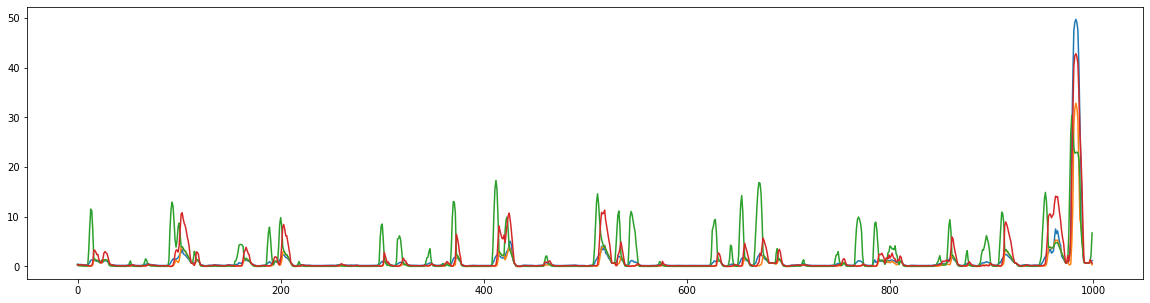

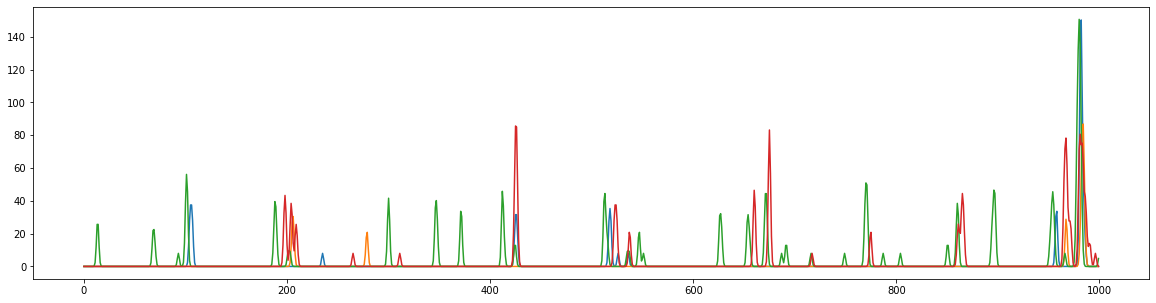

In [19]:
print(test_pc_noise)
plt.figure(figsize=(20,5))
plt.plot(pred_noise[5000:6000])
plt.show()
plt.figure(figsize=(20,5))
plt.plot(targ_noise[5000:6000])
plt.show()

In [27]:
nn.MSELoss()(torch.tensor(pred_noise2[:]), torch.tensor(targ_noise2[:]))

tensor(70.1967, dtype=torch.float64)

In [28]:
nn.PoissonNLLLoss(log_input=False)(torch.tensor(pred_noise2[:]), torch.tensor(targ_noise2[:]))

tensor(-3.8380, dtype=torch.float64)

In [4]:
data_kwargs = dict(cfg.Data)
data_kwargs['stim'] = 'fullfield_whitenoise'
train_dataset = MyDataset(stim_sec='train', **data_kwargs)
train_data = DataLoader(dataset=train_dataset)
epoch_loss = 0
hs = get_hs(model, 1, device, I20=None, mode='single')
y_preds = []
y_targs = []
with torch.no_grad():
    for idx,(x,y) in enumerate(tqdm(train_data)):
        x = x.to(device)
        y = y.double().to(device)
        out, hs = model(x, hs)
        y_preds.append(out.double())
        y_targs.append(y)
        if idx % 1000 == (1000 - 1):
            y_pred = torch.stack(y_preds, dim=2)
            y_targ = torch.stack(y_targs, dim=2)
            loss = nn.MSELoss()(y_pred, y_targ)
            epoch_loss += loss.detach().cpu().numpy()
            y_preds = []
            y_targs = []
    epoch_loss = epoch_loss / len(train_dataset) * 1000

100%|██████████| 239960/239960 [10:04<00:00, 396.84it/s]


In [5]:
epoch_loss

165.6877691658664

In [5]:
data_kwargs = dict(cfg.Data)
data_kwargs['stim'] = 'fullfield_whitenoise'
train_dataset = MyDataset(stim_sec='train', **data_kwargs)
train_data = DataLoader(dataset=train_dataset)
epoch_loss = 0
hs = get_hs(model, 1, device, I20=None, mode='single')
y_preds = []
y_targs = []
with torch.no_grad():
    for idx,(x,y) in enumerate(tqdm(train_data)):
        x = x.to(device)
        y = y.double().to(device)
        out, hs = model(x, hs)
        y_preds.append(out.double())
        y_targs.append(y)
        if idx % 1000 == (1000 - 1):
            y_pred = torch.stack(y_preds, dim=2)
            y_targ = torch.stack(y_targs, dim=2)
            loss = temporal_frequency_normalized_loss(y_pred, y_targ, nn.MSELoss(), device, num_units=4)
            epoch_loss += loss.detach().cpu().numpy()
            y_preds = []
            y_targs = []
    epoch_loss = epoch_loss / len(train_dataset) * 1000
print(epoch_loss)

100%|██████████| 239960/239960 [11:31<00:00, 347.02it/s]

1.5194952346510076


In [17]:
bad_pairs = []
data_kwargs = dict(cfg.Data)
data_kwargs['stim'] = 'fullfield_whitenoise'
train_dataset = MyDataset(stim_sec='train', **data_kwargs)
train_data = DataLoader(dataset=train_dataset)
epoch_loss = 0
hs = get_hs(model, 1, device, I20=None, mode='single')
y_preds = []
y_targs = []
with torch.no_grad():
    for idx,(x,y) in enumerate(train_data):
        x = x.to(device)
        y = y.double().to(device)
        out, hs = model(x, hs)
        y_preds.append(out.double())
        y_targs.append(y)
        if idx % 1000 == (1000 - 1):
            y_pred = torch.stack(y_preds, dim=2)
            y_targ = torch.stack(y_targs, dim=2)
            loss = temporal_frequency_normalized_loss(y_pred, y_targ, nn.MSELoss(), device, num_units=4)
            epoch_loss += loss.detach().cpu().numpy()
            if loss.detach().cpu().numpy() > 20000:
                bad_pairs.append((y_pred.detach().cpu().numpy(), y_targ.detach().cpu().numpy()))
            y_preds = []
            y_targs = []
    epoch_loss = epoch_loss / len(train_dataset) * 1000
print(epoch_loss)

4354.581036677701


In [19]:
with torch.no_grad():
    for pair in bad_pairs:
        print(nn.MSELoss()(torch.tensor(pair[0]), torch.tensor(pair[1])).cpu().numpy())

10.741528187317567
103.22745968357671
163.26002847138582
108.52475976525263
86.16168600095436
95.88104779998604
84.60100939010587
62.502890267669216
105.16013824726929
143.53355401612683
142.63076737780543
110.5152577634835
137.8416774743536
120.85746591812753
48.30170193338956
147.2866964009466
150.14650372064875
151.33332200654596


In [33]:
with torch.no_grad():
    for pair in bad_pairs:
        print(temporal_frequency_normalized_loss(torch.tensor(pair[0][:,0:1]).to(device), torch.tensor(pair[1][:,0:1]).to(device), nn.MSELoss(), device, num_units=1).cpu().numpy())

1.8194208363824322
1.5898946697857594
2.002422107679731
1.9778778032514022
1.790119381985521
1.969285321214386
1.8608692242358638
1.9515710965031574
202832.72221460653
109050.44213987728
205556.10661079676
95021.22790521
209791.50602081526
154489.59383149727
71865.98457462298
2.679252389972313
199745.21196006847
640719.9747170131


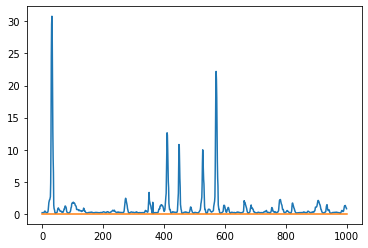

In [43]:
plt.plot(bad_pairs[14][0][0,0])
plt.plot(bad_pairs[14][1][0,0])

In [56]:
bad_pairs[14][1].shape

(1, 4, 1000)

In [57]:
stds = []
data_kwargs = dict(cfg.Data)
data_kwargs['stim'] = 'fullfield_whitenoise'
train_dataset = MyDataset(stim_sec='train', **data_kwargs)
train_data = DataLoader(dataset=train_dataset)
epoch_loss = 0
hs = get_hs(model, 1, device, I20=None, mode='single')
y_preds = []
y_targs = []
with torch.no_grad():
    for idx,(x,y) in enumerate(train_data):
        y_targs.append(y.cpu().numpy())
        if idx % 1000 == (1000 - 1):
            y_targ = np.stack(y_targs, axis=2)
            stds.append(y_targ.std(-1)[0])
            y_targs = []

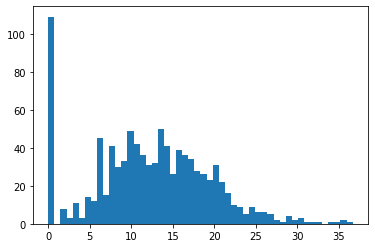

In [61]:
plt.hist(np.array(stds).flatten(), bins=50)
plt.show()

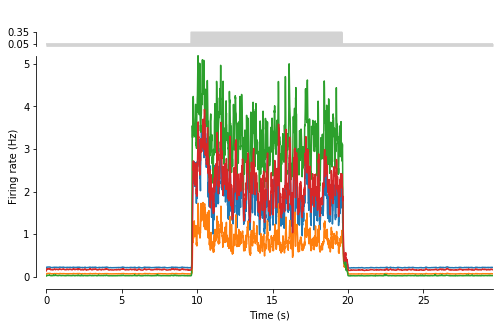

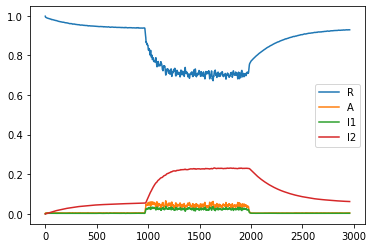

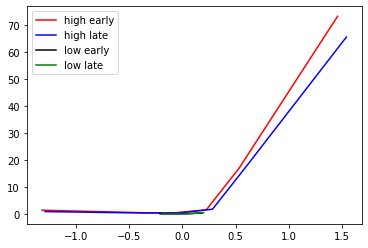

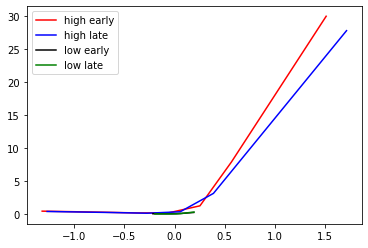

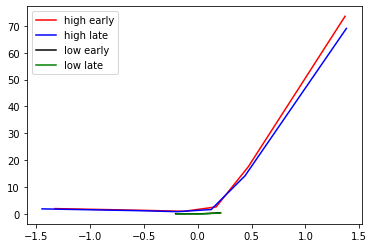

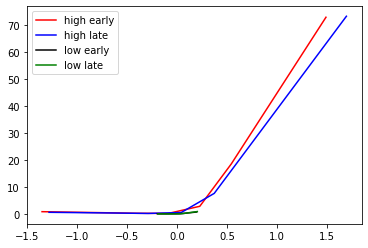

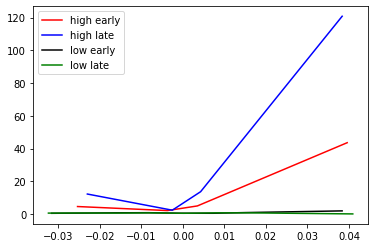

white noise prediction correlation :0.5867
natural scene prediction correlation: 0.6052


(0.5867187410334063,
 0.6051543843439129,
 {'kinetics': array([[[9.97351706e-01, 9.17568982e-01, 9.93604660e-01, ...,
           9.96685803e-01, 9.91852343e-01, 9.96357441e-01],
          [2.64838268e-03, 8.24310407e-02, 6.39529992e-03, ...,
           3.31406761e-03, 8.14786647e-03, 3.64243565e-03],
          [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
           0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
          [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
           0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],
  
         [[9.94799018e-01, 8.45526338e-01, 9.87214267e-01, ...,
           9.93501902e-01, 9.84302461e-01, 9.92766559e-01],
          [3.96336801e-03, 1.15960397e-01, 9.79790278e-03, ...,
           4.94959345e-03, 1.18906889e-02, 5.53141301e-03],
          [1.23737496e-03, 3.85133587e-02, 2.98800739e-03, ...,
           1.54839619e-03, 3.80684016e-03, 1.70181587e-03],
          [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          

In [11]:
device = torch.device('cuda:2')
checkpoint_path = '/home/xhding/saved_model/kinetics_both/epoch_045_loss_-60.15_pearson_natural_0.4562_pearson_noise_0.4354.pth'
checkpoint_path_one_pixel = '/home/xhding/saved_model/kinetics_one_pixel/epoch_005_loss_1.46_pearson_0.4466.pth'
cfg_name = 'kinetics_both'
analyze(cfg_name, checkpoint_path, checkpoint_path_one_pixel, stimulus, device, nrepeats=100, n_units=4, channel=0, cell=0, h_start=2000, l_start=4000)

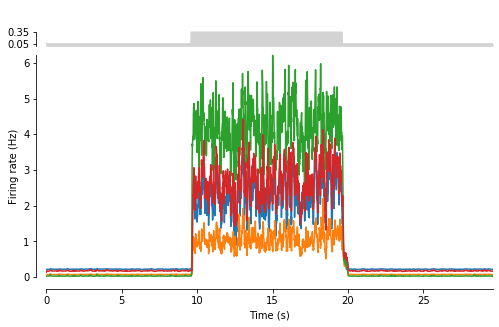

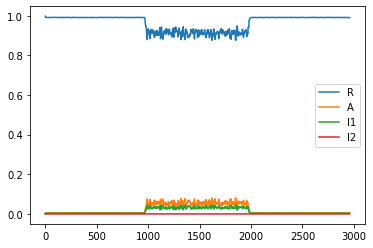

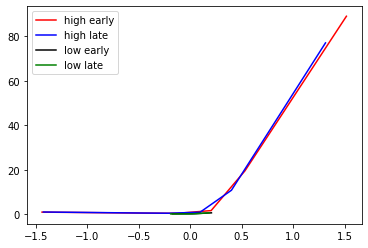

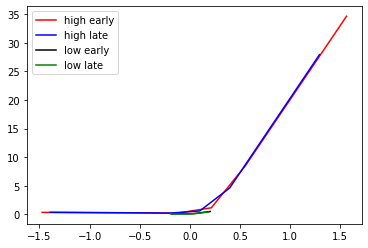

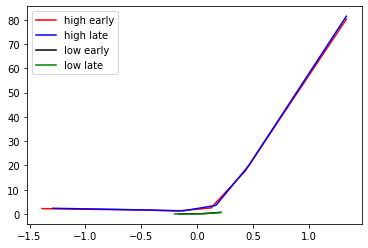

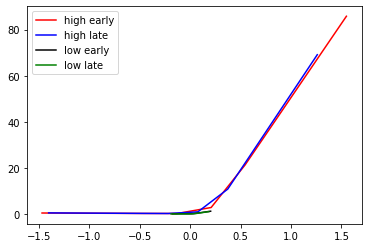

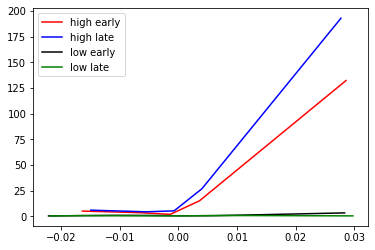

white noise prediction correlation :0.5791
natural scene prediction correlation: 0.6042


(0.5791256893926713,
 0.6042041973542988,
 {'kinetics': array([[[0.9974572 , 0.9193604 , 0.9936801 , ..., 0.9968186 ,
           0.9929715 , 0.9966558 ],
          [0.00254259, 0.08063954, 0.00631983, ..., 0.00318127,
           0.00702841, 0.00334402],
          [0.        , 0.        , 0.        , ..., 0.        ,
           0.        , 0.        ],
          [0.        , 0.        , 0.        , ..., 0.        ,
           0.        , 0.        ]],
  
         [[0.99484146, 0.85215956, 0.9874408 , ..., 0.9935442 ,
           0.98635465, 0.9933708 ],
          [0.00397072, 0.11016379, 0.00960674, ..., 0.00496945,
           0.01036156, 0.00506673],
          [0.00118795, 0.03767636, 0.00295275, ..., 0.00148635,
           0.00328381, 0.00156239],
          [0.        , 0.        , 0.        , ..., 0.        ,
           0.        , 0.        ]],
  
         [[0.9931632 , 0.81974816, 0.98354876, ..., 0.99132884,
           0.9825051 , 0.9913578 ],
          [0.00473402, 0.12092772, 0.0

In [12]:
device = torch.device('cuda:2')
checkpoint_path = '/home/xhding/saved_model/kinetics_both/epoch_045_loss_-60.15_pearson_natural_0.4562_pearson_noise_0.4354.pth'
checkpoint_path_one_pixel = ''
cfg_name = 'kinetics_both'
analyze(cfg_name, checkpoint_path, checkpoint_path_one_pixel, stimulus, device, nrepeats=100, n_units=4, channel=0, cell=0, h_start=2000, l_start=4000)

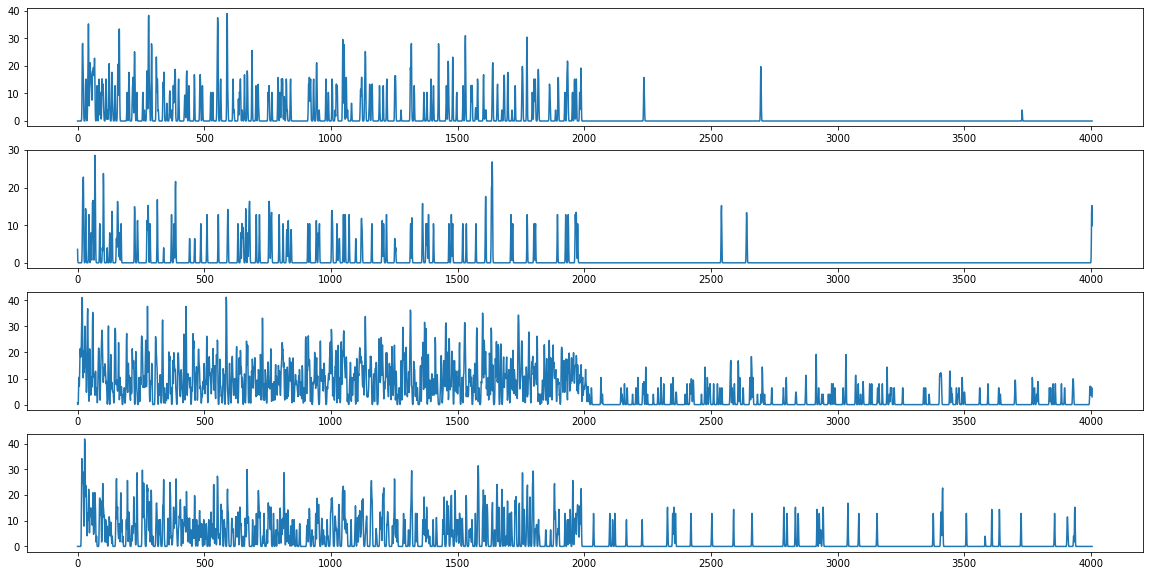

In [19]:
fig,ax = plt.subplots(4,1,figsize=(20,10))
for i, cell in enumerate([1,2,7,10]):
    ax[i].plot(responses.mean(0)[:, cell])
plt.show()

In [3]:
device = torch.device('cuda:2')
checkpoint_path = '/home/xhding/saved_model/kinetics_both/epoch_045_loss_-60.15_pearson_natural_0.4562_pearson_noise_0.4354.pth'
checkpoint_path_one_pixel = '/home/xhding/saved_model/kinetics_one_pixel/epoch_005_loss_1.46_pearson_0.4466.pth'
cfg = get_custom_cfg('kinetics_both')
checkpoint = torch.load(checkpoint_path, map_location=device)
model_func = getattr(models, cfg.Model.name)
model_kwargs = dict(cfg.Model)
model = model_func(**model_kwargs).to(device)
model.load_state_dict(checkpoint['model_state_dict'])
if checkpoint_path_one_pixel != '':
    checkpoint_one_pixel = torch.load(checkpoint_path_one_pixel, map_location=device)
    model.kinetics.ksi.data = checkpoint_one_pixel['model_state_dict']['kinetics.ksi']
    model.kinetics.ksr.data = checkpoint_one_pixel['model_state_dict']['kinetics.ksr']
    try:
        if model.ksr_gain:
            model.kinetics.ksr_2.data = checkpoint_one_pixel['model_state_dict']['kinetics.ksr_2']
    except:
        pass
model.eval()

KineticsModel(
  (bipolar): Sequential(
    (0): LinearStackedConv2d(
      bias=True, abs_bnorm=False
      (convs): Sequential(
        (0): Conv2d(40, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (1): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (4): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (5): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (6): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
      )
    )
    (1): Sigmoid()
    (2): Reshape(shape=(-1, 8, 1296))
  )
  (kinetics): Kinetics()
  (spiking_block): Sequential(
    (0): ReLU()
  )
  (amacrine): Sequential(
    (0): Reshape(shape=(-1, 8, 36, 36))
    (1): LinearStackedConv2d(
      bias=True, abs_bnorm=False
      (convs): Sequential(
        (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bi

In [23]:
fullfield_dataset = MyDataset('validation', (40,50,50), '/home/xhding/tem_stim', '21-01-26', 'fullfield', 0, cells=[1,2,7,10])
fullfield_data =  DataLoader(fullfield_dataset)
pearson, val_pred, val_targ = pearsonr_eval(model, fullfield_data, 4, device, with_responses=True)

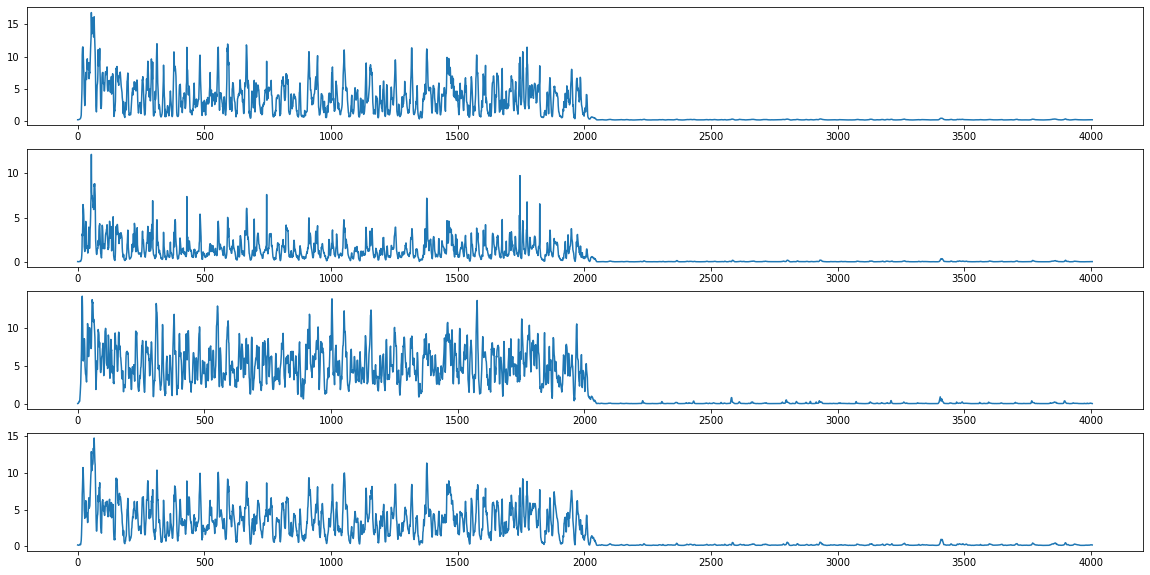

In [26]:
responses = val_pred[3966:40020, :].reshape((9, -1, 4))
fig,ax = plt.subplots(4,1,figsize=(20,10))
for i in range(4):
    ax[i].plot(responses.mean(0)[:, i])
plt.show()

In [5]:
data_kwargs = dict(cfg.Data)
data_kwargs['stim'] = 'naturalscene'
train_dataset_natural = MyDataset(stim_sec='train', **data_kwargs)
test_data_natural =  DataLoader(dataset=MyDataset(stim_sec='test', stats=train_dataset_natural.stats, **data_kwargs))
pearson, pred, targ = pearsonr_eval(model, test_data_natural, 4, device, with_responses=True)

In [10]:
with h5py.File('/home/xhding/tem_stim/21-01-26/naturalscene.h5', 'r') as f:
    stimulus =  np.asarray(f['test']['stimulus']).astype('float32')
    resp = np.asarray(f['test']['response']['firing_rate_10ms'])

In [15]:
contrasts = (stimulus.reshape(60,100,50,50).std(1)/stimulus.reshape(60,100,50,50).mean(1)).mean((-1,-2))
contrasts = np.repeat(contrasts, 100)

In [ ]:
pred_pad = np.pad(pred, ((40, 0),(0,0)), 'constant', constant_values=(0, 0))

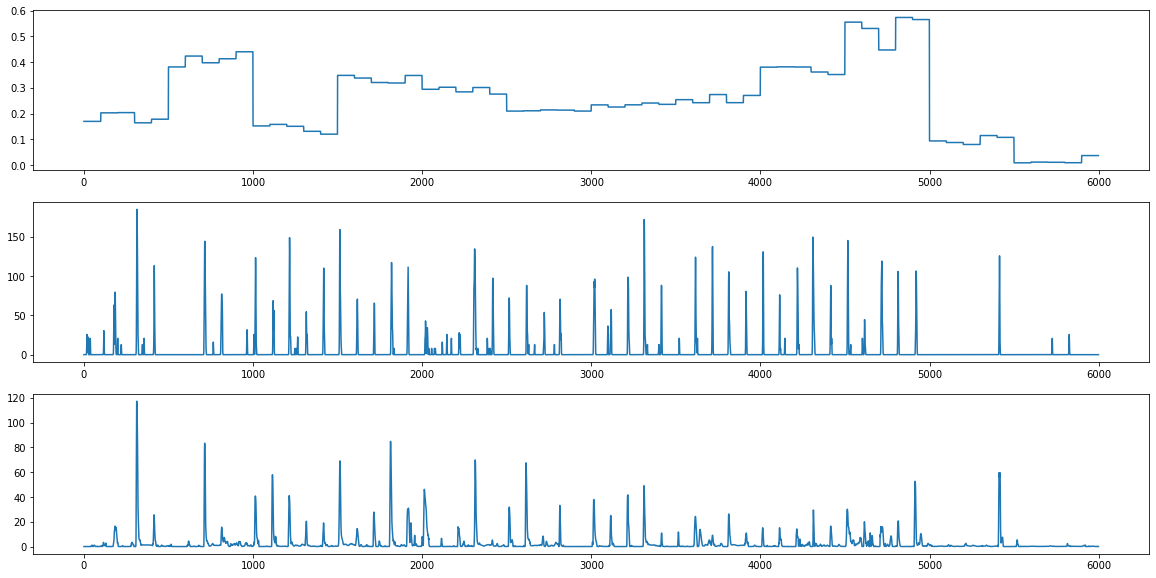

In [31]:
cell = 1
fig,ax = plt.subplots(3,1,figsize=(20,10))
ax[0].plot(contrasts)
ax[1].plot(resp[cell])
ax[2].plot(pred_pad[:,cell])
plt.show()